# Сравнительное исследование методов внутренней мотивации

Работая с одной и той же средой, мы можем преследовать разные цели, используя разные функции награды и, таким образом, оптимизируя разные целевые функционалы. Добавление некоторой искусственной (внутренней) награды имеет смысл, например, в случае разреженности награды, данной в задаче изначально (внешней). Внутренняя награда задаёт так называемую внутреннюю мотивацию агента, что является аналогией одноименноого понятия из психологии. Идея внутренней мотивации заключается в побуждении агента к исследованию среды, когда он получает внутреннюю награду при наблюдении нового или неожиданного в ходе взаимодействий с ней.

Мы сравним несколько self-supervised подходов к заданию внутренней функции награды для лучшего исследования среды:

- Forward dynamics model
- Inverse dynamics model
- Intrinsic curiosity module (ICM)
- Random network distillation (RND)

В качестве среды возьмем MountainCar-v0.

## Forward dynamics model
    
Пусть $f(s, a)$ - модель, которая предсказывает следющее состояние $s'$. Ошибку этой модели и возьмём за внутреннюю функцию награды.
$$\frac{1}{2}\left\|f(s, a)-s^{\prime}\right\|_{2}^{2} \rightarrow \min _{f}, \quad r^{\text {intr }}\left(s, a, s^{\prime}\right):=\frac{1}{2}\left\|f(s, a)-s^{\prime}\right\|_{2}^{2}$$

Заметим, что среда MountainCar-v0, на которой мы будем проводить эксперименты, является детерменированной. Поэтому мы можем не опасаться проблемы шумного телевизора и взять за $f$ детерминированную функцию, такую как, например, обычный MLP.

## Inverse dynamics model

<img src="pics/inverse_dynamics.png" width="600"/>

В случае модели обратной динамики будем предсказывать уже выбранное действие $a$ по текущему $s$ и следующему $s'$ состояниям.
За внутреннюю награду берется кросс-энтропийная ошибка модели.

$$L_{cross\,entropy}\left(f(s, s'), a\right) \rightarrow \min _{f}, \quad r^{\text {intr }}\left(s, a, s^{\prime}\right):=L_{cross\,entropy}\left(f(s, s'), a\right)$$

## ICM

<img src="pics/ICM.png" width="500" />

Внутренний модуль любопытства является объединением идей моделей прямой и обратной динамики.
Модель обратной динамики хороша тем, что позволяет получить качественные эмбеддинги для состояний.
Имея их, мы можем использовать модель прямой динамики для работы в пространстве эмбеддингов, что особенно актуально в случае, если состояния - это сырые картинки, в которых, как правило, много лишней информации.

$$L_{forward}(\phi(s), a, \phi(s'); f) + \eta L_{inverse}(s, a, a'; f) \rightarrow \min _{f}, \quad r^{\text {intr }}\left(s, a, s^{\prime}\right):= L_{forward}(s, a, s'; f)$$

Ошибка модели обратной динамики работает как регуляризатор и помогает найти лучшие представления состояний, модель прямой динами предсказывает уже эмбеддинг следующего состояния по эмбеддингу текущего состояния и действию.

В оригинальной статье ICM модуль оптимизировался совместно с основным целевым функционалом алгоритма, но мы будем обучать их раздельно, так как для основного функционала будем семплировать внутреннюю награду из буфера памяти.

## RND
<img src="pics/RND.png" width="600" />

Мы инициализируем некоторую случайную сеть, фиксируем её и учимся предсказывать её выход такой же сетью на наблюдаемых в среде состояниях. Ошибкк в предсказании, опять же, будем считать мерой новизны состояния и возьмём внутреннюю награду равной этой ошибке.

$$r^{\text {intr }}(s):=\frac{1}{2}\left\|\phi^{\text {predictor }}(s)-\phi^{\text {target }}(s)\right\|_{2}^{2}$$

## Среда MountainCar-v0

<img src="pics/mountaincar.gif" width="400" />

Имеется машина, в начале эпизода расположенная в яме. Требуется с помощью толчков закатить её на вершину холма.

Пространство состояний - это пары из позиций и скоростей машины, лежащих в отрезках $\left[-1.2, 0.6\right]$ и $\left[-0.07, 0.07\right]$ соответственно. 
На каждом шаге на выбор имеется три действия: толкнуть машину влево, не толкать её или толкнуть вправо.
Вершина холма находится на позиции $0.5$. В начале эпизода машина имеет нулевую скорость и случайную позицию в отрезке $[-0.6, -0.4]$.

Максимальная длина эпизода - $200$ шагов, эпизод может закончиться раньше, если машина успеет достигнуть вершины.
Каждый шаг агент получает награду, равную $-1$. Таким образом, единственный способ увеличить return - это завершить эпизод как можно раньше.

Внешняя награда ничего не говорит агенту о том, насколько хороши его действия, пока ему не удастся добраться до вершины холма, поэтому логично предположить, что внутренняя мотивация поможет лучше исследовать среду в этой задаче и быстрее достигнуть большей награды.

Задача считается решенной, если агент получил среднюю кумулятивную награду за последние $100$ эпизодов выше $-110$.
Поэтому для оценки работы алгоритмов будем изображать кумулятивную награду агента по эпизодам, сглаженную скользящим средним с окном $100$. 
Помимо сглаживания шумных кривых, это позволит видеть более наглядно, решена ли была задача. Будем отрисовывать кривые, усредняя их по 5 запускам, изображая среднее и стандартное отклонение в каждом эпизоде.

## Гиперпараметры

В качестве сетей в моделях внутренней мотивации почти везде используются модели с двумя линейными слоями, ReLU активацией между ними и линейной активацией на конце. В RND используется 256 нейронов, в curiosity-моделях - 128. Для кодирования состояний в curiosity-моделях используется как энкодер используется такая же сеть, но с 64 нейронами в слоях. В приведенных запусках в RND не делалась нормировка внутренней награды, так как это приводило к существенно более худшей работе. Возможно, нормировка требует переподбора гиперпараметров.

$\gamma = 0.99$, $\epsilon$-жадный эксплорейшн затухает от 1.0 до 0.01, умножаясь на 0.9 каждый эпизод.
В сети QR-DQN используется 3 линейных слоя с 256 нейронами и ReLU активацией после первого и второго. Сеть учится предсказывать 5 квантилей распределения $Z(s, a)$.
Для оптимизации QR-DQN и моделей внутренней мотивации используется Adam с lr=1e-3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path
from os import listdir
from os.path import isfile, join
from qr_dqn import QuantileRegressionDQN
from utils import fix_seed
from matplotlib import animation
import time
import matplotlib
import torch
import gym
%matplotlib inline

In [2]:
def moving_average(array):
    return pd.Series(array).rolling(100).mean()

In [3]:
def plot_with_std(ax, path, label, color, intr=False, averaging=True):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    if intr:
        files = list(filter(lambda x: "int" in x and ".npy" in x, files))
    else:
        files = list(filter(lambda x: "int" not in x and ".npy" in x, files))
    df = pd.DataFrame()
    for i, file in enumerate(files):
        df[i] = np.load(join(path, file))
        if averaging:
            df[i] = moving_average(df[i])
    means = df.mean(axis=1)
    stds = df.std(axis=1)
    
    ax.plot(means.index, means, alpha=1.0, label=label, linewidth=2, color=color)
    ax.fill_between(means.index, means - stds, means + stds, alpha=0.25, color=color)
    return means, stds

def get_folders(path, algos, suffix):
    return list(map(lambda algo: join(path, algo) + f"_{suffix}", algos))

Мы решили реализовать механизм внутренней мотивации для off-policy алгоритма следующим образом: на каждом шаге взаимодействия со средой агент получает как внешнюю награду, так и внутреннюю, обе они кладутся в буфер, на одном и том же семпле из буфера далее обучается и основной алгоритм, и модель внутренней мотивации. Недостатком такого подхода может быть хранение застарелых значений функции внутренней награды в буфере памяти, но при этом стоит заметить, что если награда уменьшится для тех же входных данных со временем, то и ожидаемое значение внутреннего реворда, получаемого из буфера - тоже. Тем не менее, отсюда возникает желание посмотреть, что произойдет в случае с меньшим размером памяти.

Изначальный размер реплея - 100000.

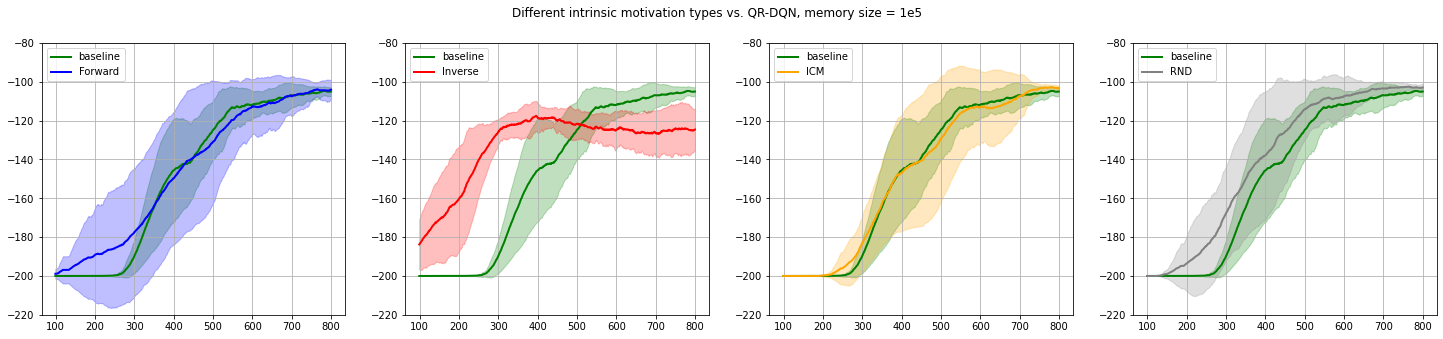

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

path = "logs"
algorithms = ["baseline", "Forward", "Inverse", "ICM", "RND"]
paths = get_folders("logs", algorithms, 100000)
colors = ["green", "blue", "red", "orange", "gray"]
for i in range(4):
    means, stds = plot_with_std(ax[i], paths[0], algorithms[0], colors[0])
    means, stds = plot_with_std(ax[i], paths[i + 1], algorithms[i + 1], colors[i + 1])
    ax[i].legend(loc="upper left")
    ax[i].grid()
    ax[i].set_ylim(-220, -80)
fig.suptitle("Different intrinsic motivation types vs. QR-DQN, memory size = 1e5");

Мы видим явное (пусть и не столь значительное на вид) превосходство внутренней мотивации против чистого QR-DQN только в случае RND.
Однако, если приглядеться, видно, что все методы в среднем хотя бы немного раньше начинают наращивать кумулятивную награду, чем это начинает делать QR-DQN.
Особенно сильно отрыв от минимальных значений виден у модели обратной динамики.
Если взглянуть на какой-нибудь из запусков, мы увидим, что она уже на тридцатых эпизодах способна заставить машину додниматься в гору. А деградация агента ближе к концу может быть объяснена перестройкой алгоритма на менее изученные действия в среде, что кажется нормальным эффектом при использовании алгоритмов данного семейства, или накопившимся, но уже нерелевантным опытом в буфере. Однако, как будет видно ниже, внутренняя награда затухает со временем, а уменьшение буфера не идет на пользу модели обратной динамики.

The first time the agent achieved the flag is 32


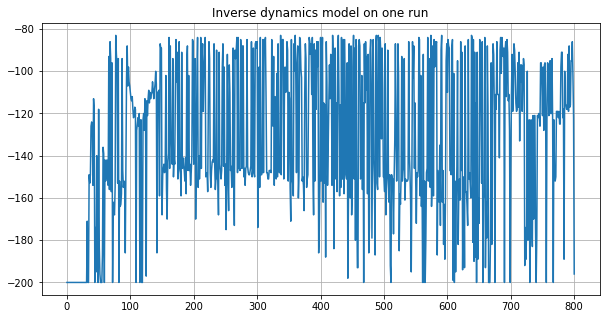

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

inverse_rewards_one_run = np.load("logs/Inverse_100000/Inverse_0.npy")
ax.plot(inverse_rewards_one_run)
plt.title("Inverse dynamics model on one run")
plt.grid()

for i in range(len(inverse_rewards_one_run)):
    if inverse_rewards_one_run[i] > -200:
        break
    
print(f"The first time the agent achieved the flag is {i}")

Есть гипотеза, что разница в поведении алгоритмов может заключаться в разном масштабе наград, и можно и другие алгоритмы внутренней мотивации использовать, чтобы давать подобный прирост в начале обучения. Поэтому имеет смысл взглянуть на масштаб внутренней награды для разных алгоритмов

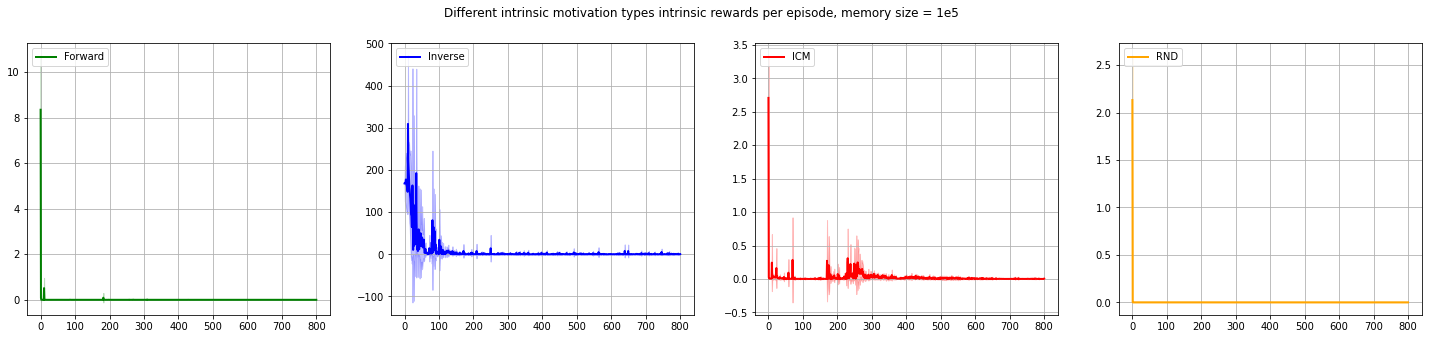

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

path = "logs"
algorithms = ["Forward", "Inverse", "ICM", "RND"]
paths = get_folders("logs", algorithms, 100000)
colors = ["green", "blue", "red", "orange", "gray"]
for i in range(4):
    means, stds = plot_with_std(ax[i], paths[i], algorithms[i], colors[i], intr=True, averaging=False)
    ax[i].legend(loc="upper left")
    ax[i].grid()
fig.suptitle("Different intrinsic motivation types intrinsic rewards per episode, memory size = 1e5");

Налицо видна разница в масштабах, откуда возникает желание попробовать разные значения множителя $\eta$ в сумме наград $r_e + \eta * r_i$, который был равен 1 в рассмотренных выше запусках.

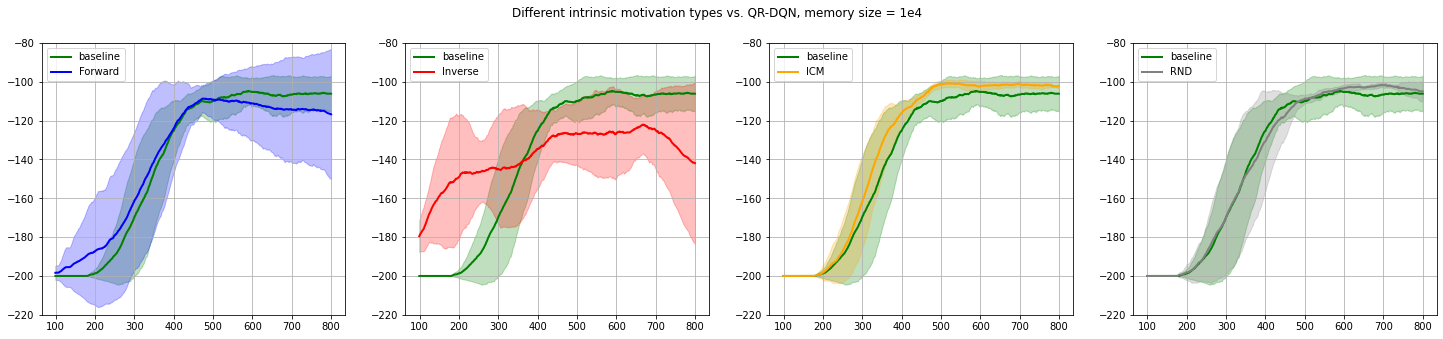

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

path = "logs"
algorithms = ["baseline", "Forward", "Inverse", "ICM", "RND"]
paths = get_folders("logs", algorithms, 10000)
colors = ["green", "blue", "red", "orange", "gray"]
for i in range(4):
    means, stds = plot_with_std(ax[i], paths[0], algorithms[0], colors[0])
    means, stds = plot_with_std(ax[i], paths[i + 1], algorithms[i + 1], colors[i + 1])
    ax[i].legend(loc="upper left")
    ax[i].grid()
    ax[i].set_ylim(-220, -80)
fig.suptitle("Different intrinsic motivation types vs. QR-DQN, memory size = 1e4");

Уменьшение размера памяти не слишком негативно сказалось на основном алгоритме, но ухудшило поведение у первых двух моделей с внутренней мотивацией. Интересно то, как уменьшился разброс в поведении ICM и RND. Возможно, что они вместе с меньшим буфером памяти заставили агента обучаться более стабильно.

Предельный случай: буфер памяти размером в тысячу. Основной алгоритм справляется уже заметно хуже, но видно, что RND и ICM более заметно ему помогают.

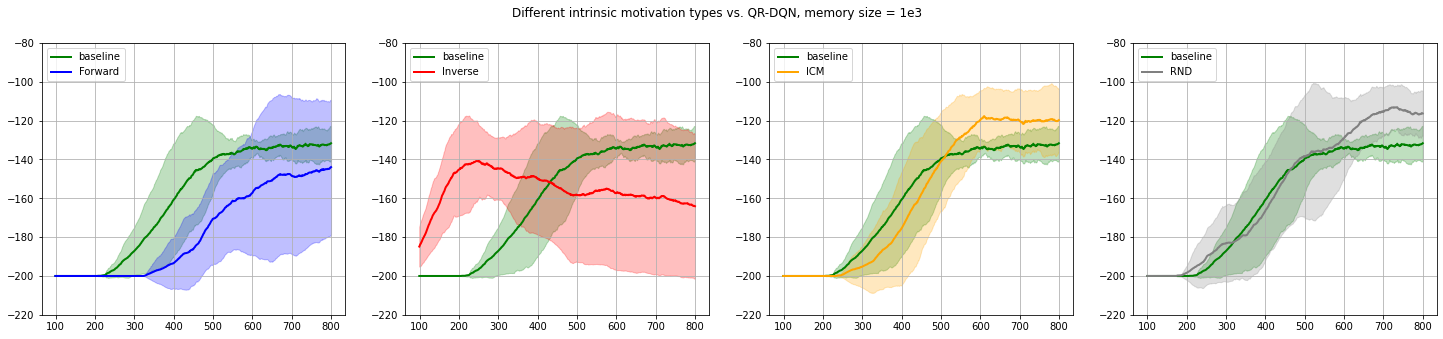

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

path = "logs"
algorithms = ["baseline", "Forward", "Inverse", "ICM", "RND"]
paths = get_folders("logs", algorithms, 1000)
colors = ["green", "blue", "red", "orange", "gray"]
for i in range(4):
    means, stds = plot_with_std(ax[i], paths[0], algorithms[0], colors[0])
    means, stds = plot_with_std(ax[i], paths[i + 1], algorithms[i + 1], colors[i + 1])
    ax[i].legend(loc="upper left")
    ax[i].grid()
    ax[i].set_ylim(-220, -80)
fig.suptitle("Different intrinsic motivation types vs. QR-DQN, memory size = 1e3");

Интересно, что даже при малом масштаб награды, выдаваемой последними двумя моделями, мы наблюдаем улучшения.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def save_frames_as_gif(frames, filename='./gym_animation.gif'):

    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(filename, writer='imagemagick', fps=60)
    plt.close()

In [11]:
env = gym.envs.make("MountainCar-v0")
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

def run_eval(weights_path, episodes_num=10, decay=0.01, generate_gif=False, gif_name='gym_animation.gif'):
    Z_net = QuantileRegressionDQN(observation_dim=obs_dim, n_actions=n_actions).to(device)
    Z_net.load_state_dict(torch.load(weights_path))
    Z_net.eval()

    frames = []
    for episode in range(episodes_num):
        state = env.reset()
        while True:
            frames.append(env.render(mode="rgb_array"))
            time.sleep(decay)
            action = Z_net.act(torch.Tensor([state]).to(device), 0.0)
            next_state, ext_reward, done, _ = env.step(action)
            state = next_state
            if done:
                break        
    env.close()
    if generate_gif:
        save_frames_as_gif(frames, gif_name)

In [12]:
weights_list = ["logs/baseline_100000/QR_DQN_None_0_weights",
                "logs/Forward_100000/QR_DQN_Forward_0_weights",
                "logs/Inverse_100000/QR_DQN_Inverse_0_weights",
                "logs/ICM_100000/QR_DQN_ICM_0_weights",
                "logs/RND_100000/QR_DQN_RND_0_weights"]

gif_names = ['pics/pure_qr_dqn.gif', 'pics/forward.gif', 
             'pics/inverse.gif', 'pics/ICM.gif', 'pics/RND.gif']

for weights_path, gif_name in zip(weights_list, gif_names):
    fix_seed(100, env)
    run_eval(weights_path, 3, generate_gif=False, gif_name=gif_name)

| Pure QR-DQN | Forward Dynamics | Inverse Dynamics | ICM | RND |
| --- | --- | --- | --- | --- |
| <img src='pics/pure_qr_dqn.gif' style="width: 200px;"/> | <img src='pics/forward.gif' style="width: 200px;"/> | <img src='pics/inverse.gif' style="width: 200px;"/> | <img src='pics/ICM.gif' style="width: 200px;"/> | <img src='pics/RND.gif' style="width: 200px;"/> |
